ResNet50 Model for the Detection Of DFU

Import Libaraies

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


In [7]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torchvision.models import ResNet50_Weights

In [9]:
# Dataset path
DATASET_PATH = r"D:\Academics\ML_Proj\Dataset\Training_set"


scene_categories = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Classes:", scene_categories)


Classes: ['DFU', 'Non DFU']


Data Preprocessing 

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.classes}")


Total images: 289
Classes: ['DFU', 'Non DFU']


Model defining

In [15]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)


num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),   
    nn.Linear(num_ftrs, 2)) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Setting Loss function and Optimizer function

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001 , weight_decay=1e-5)

Training Loop

In [21]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.2433
Epoch [2/10], Loss: 0.0636
Epoch [3/10], Loss: 0.6496
Epoch [4/10], Loss: 0.0717
Epoch [5/10], Loss: 0.0391
Epoch [6/10], Loss: 0.0095
Epoch [7/10], Loss: 0.0033
Epoch [8/10], Loss: 0.5162
Epoch [9/10], Loss: 0.1083
Epoch [10/10], Loss: 0.3797


Test_images preprocessing

In [23]:
TESTSET_PATH = r"D:\Academics\ML_Proj\Dataset\Test_set"

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_dataset = datasets.ImageFolder(root=TESTSET_PATH, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test Classes: {test_dataset.classes}")
print(f"Total test images: {len(test_dataset)}")


Test Classes: ['DFU', 'Non DFU']
Total test images: 262


In [28]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1) 
        all_preds.extend(preds.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Test Accuracy: 0.9160
              precision    recall  f1-score   support

         DFU       0.94      0.93      0.94       176
     Non DFU       0.86      0.88      0.87        86

    accuracy                           0.92       262
   macro avg       0.90      0.91      0.91       262
weighted avg       0.92      0.92      0.92       262



Confusion Matrix

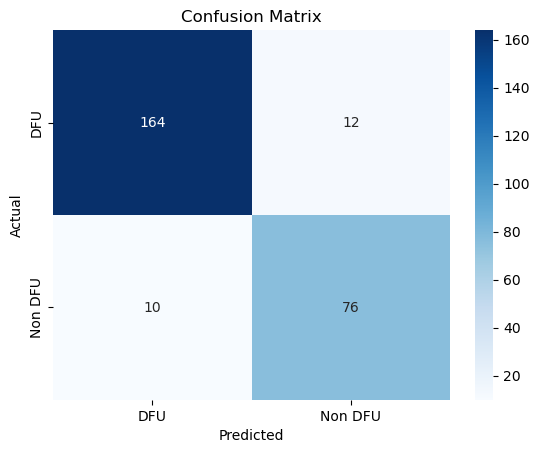

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Prediction

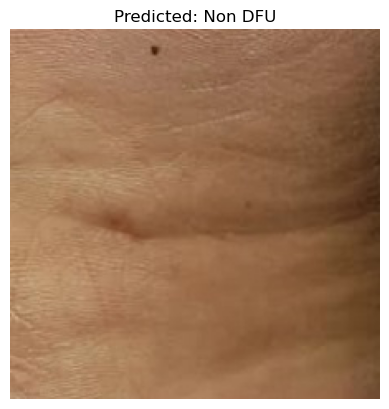

Predicted class: Non DFU


In [46]:
model.eval()


image_path = r"C:\Users\hp\Downloads\516.jpg"
image = Image.open(image_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ])

image_tensor = transform(image).unsqueeze(0)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)
model = model.to(device)

with torch.no_grad():  
    output = model(image_tensor)  

_, predicted_class = torch.max(output, 1)  

class_names = ['DFU', 'Non DFU']  
predicted_label = class_names[predicted_class.item()]


plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off') 
plt.show()


print(f'Predicted class: {predicted_label}')


Probability

In [30]:
probabilities = torch.nn.functional.softmax(output, dim=1)
print(probabilities)


tensor([[1.0000e+00, 1.7804e-18]])


In [32]:
_, predicted_class = torch.max(output, 1)
print(f"Predicted class index: {predicted_class.item()}")
predicted_label = class_names[predicted_class.item()]
print(f"Predicted label: {predicted_label}")


Predicted class index: 0
Predicted label: DFU


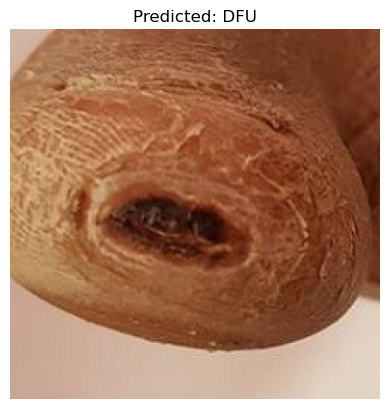

Predicted class: DFU


In [55]:
model.eval()


image_path = r"D:\Academics\ML_Proj\DFU\EXTRA\138.jpg"
image = Image.open(image_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ])

image_tensor = transform(image).unsqueeze(0)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)
model = model.to(device)

with torch.no_grad():  
    output = model(image_tensor)  

_, predicted_class = torch.max(output, 1)  

class_names = ['DFU', 'Non DFU']  
predicted_label = class_names[predicted_class.item()]


plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off') 
plt.show()


print(f'Predicted class: {predicted_label}')


In [57]:
probabilities = torch.nn.functional.softmax(output, dim=1)
print(probabilities)


tensor([[0.8335, 0.1665]])


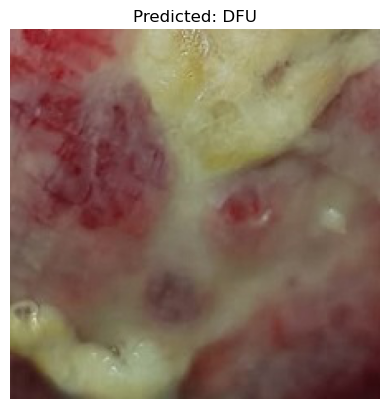

Predicted class: DFU


In [59]:
model.eval()


image_path = r"D:\Academics\ML_Proj\DFU\EXTRA\155.jpg"
image = Image.open(image_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ])

image_tensor = transform(image).unsqueeze(0)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)
model = model.to(device)

with torch.no_grad():  
    output = model(image_tensor)  

_, predicted_class = torch.max(output, 1)  

class_names = ['DFU', 'Non DFU']  
predicted_label = class_names[predicted_class.item()]


plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off') 
plt.show()


print(f'Predicted class: {predicted_label}')
